### Using Tree data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import *
import seaborn as sns

dendro = pd.read_feather("data/17766_12.feather")
dendro

,dendroNr,DOY,species,growth
0,HA_001_2012,0,Beech,0.000000
1,HA_001_2012,1,Beech,0.154100
2,HA_001_2012,2,Beech,1.460225
3,HA_001_2012,3,Beech,4.169183
4,HA_001_2012,4,Beech,3.907183
...,...,...,...,...
30805,SH_076_2013,178,Beech,3909.054208
30806,SH_076_2013,179,Beech,3908.649604
30807,SH_076_2013,180,Beech,3908.473708
30808,SH_076_2013,181,Beech,3908.421000


# Fit models

In [3]:
%%capture
# Import my GP
%run ./GP.ipynb

In [2]:
import jaxopt
import jax
import jax.numpy as jnp

dendro_spcs = dendro[dendro.species.eq("Beech")]

def weibull_F(x, lambda_, k_):
    return 1 - jnp.exp(-(lambda_ * x) ** k_)

#weibull = lambda x: 1500 * weibull_F(x.ravel(), 1/95, 3.5)#2100 * weibull_F(x.ravel(), 1 / 100, 5)  # Not accurate on to give the isotropic kernel a purpose

#df_ = dendro_spcs.groupby("DOY", as_index = False).mean(numeric_only=True)
dendro_spcs.dendroNr.unique()

array(['HA_001_2012', 'HA_001_2013', 'HA_006_2012', 'HA_006_2013',
       'HA_011_2012', 'HA_011_2013', 'HA_016_2012', 'HA_016_2013',
       'HA_017_2012', 'HA_017_2013', 'HA_018_2012', 'HA_018_2013',
       'HA_019_2012', 'HA_019_2013', 'HA_020_2012', 'HA_020_2013',
       'HA_021_2012', 'HA_021_2013', 'HA_022_2012', 'HA_022_2013',
       'HA_023_2012', 'HA_023_2013', 'HA_024_2012', 'HA_024_2013',
       'HA_025_2012', 'HA_025_2013', 'HA_026_2012', 'HA_026_2013',
       'HA_027_2012', 'HA_027_2013', 'HA_028_2012', 'HA_028_2013',
       'HA_029_2012', 'HA_029_2013', 'HA_030_2012', 'HA_030_2013',
       'HA_031_2012', 'HA_031_2013', 'HA_036_2012', 'HA_036_2013',
       'HA_037_2012', 'HA_037_2013', 'HA_038_2012', 'HA_038_2013',
       'HA_039_2012', 'HA_039_2013', 'HA_040_2012', 'HA_040_2013',
       'SA_081_2012', 'SA_081_2013', 'SA_086_2012', 'SA_086_2013',
       'SA_091_2012', 'SA_091_2013', 'SA_096_2012', 'SA_096_2013',
       'SA_101_2012', 'SA_101_2013', 'SA_102_2012', 'SA_102_20

OptStep(params=Array([2.3068337e+03, 1.0086016e-02, 3.0835240e+00], dtype=float32), state=ScipyMinimizeInfo(fun_val=Array(1068.0826, dtype=float32, weak_type=True), success=True, status=0, iter_num=32))
OptStep(params=Array([2.5328877e+03, 1.1121499e-02, 4.0812387e+00], dtype=float32), state=ScipyMinimizeInfo(fun_val=Array(2382.3308, dtype=float32, weak_type=True), success=True, status=0, iter_num=48))
OptStep(params=Array([1.6753009e+03, 9.1229249e-03, 3.2382958e+00], dtype=float32), state=ScipyMinimizeInfo(fun_val=Array(961.9237, dtype=float32, weak_type=True), success=True, status=0, iter_num=23))
OptStep(params=Array([2.4695264e+03, 1.0790442e-02, 3.9477191e+00], dtype=float32), state=ScipyMinimizeInfo(fun_val=Array(2737.3274, dtype=float32, weak_type=True), success=True, status=0, iter_num=35))
OptStep(params=Array([2.9175642e+03, 9.6337507e-03, 2.7918668e+00], dtype=float32), state=ScipyMinimizeInfo(fun_val=Array(1427.8633, dtype=float32, weak_type=True), success=True, status=0, 

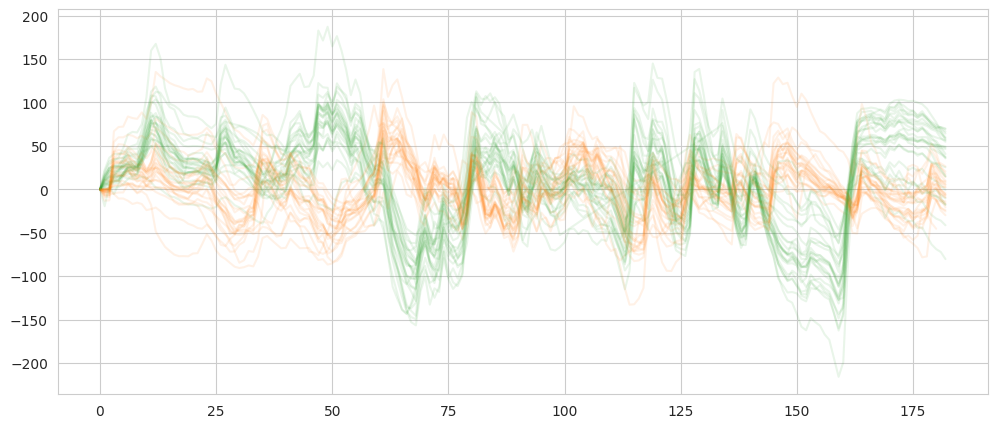

In [84]:
plt.figure(figsize=(12,5))

for i, tree in enumerate(dendro_spcs.dendroNr.unique()[:50]):
    df_ = dendro_spcs[dendro_spcs.dendroNr.eq(tree)]
    y_ = jnp.array(df_.growth)
    x_ = jnp.array(df_.DOY)

    def f_(params):
        p0, p1, p2 = params
        return jnp.mean((y_ - (p0 * weibull_F(x_, p1, p2))) ** 2)
        # return jnp.mean(
        #     jax.vmap(jax.tree_util.Partial(jaxopt.loss.huber_loss, delta = 10.))
        #     (y_, p0 * weibull_F(x_, p1, p2))
        # )

    solver = jaxopt.ScipyBoundedMinimize(fun = f_)
    res = solver.run(jnp.array([max(y_), 1/(0.632*max(y_)), 1]), jnp.array([(1, 0.0001, 1), (10000, 1, 100)]))
    weibull = lambda x__ : res.params[0] * weibull_F(x__.ravel(), res.params[1], res.params[2])

    print(res)

    #plt.plot(x_, y_, c = f"C{i}", alpha = .2, label = str(i))
    plt.plot(x_, y_ - weibull(x_), c = f"C{1 if '2012' in tree else 2}", alpha=.1)

#plt.legend()
plt.show()

250
247


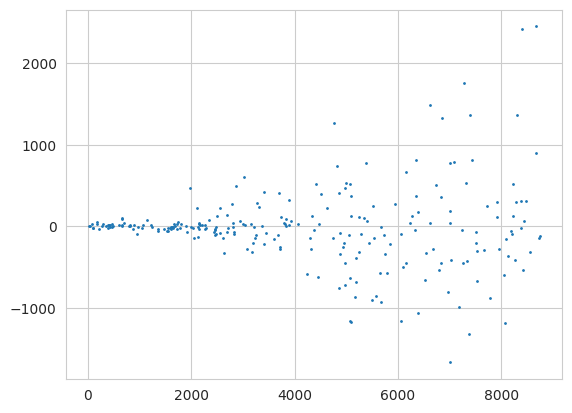

In [107]:
N = 250

rng = np.random.default_rng()
train_idx = np.sort(rng.integers(0, len(dendro_spcs), N))
print(len(train_idx))
dendro_spcs_sample = dendro_spcs.sort_values("DOY", ignore_index=True).loc[train_idx]

X_train = dendro_spcs_sample.groupby("DOY", as_index = False).mean(numeric_only=True).DOY.array.reshape(-1, 1)
y_train = dendro_spcs_sample.groupby("DOY", as_index = False).mean(numeric_only=True).growth.array
print(len(y_train))
mean_prior = weibull(X_train)
y_train -= mean_prior

plt.scatter(X_train, y_train, s = 1)

In [110]:
kernel_ = ConstantKernel(15**2) * Matern(2, nu = 5/2) + WhiteKernel(2e3) + RBF(1e-4) * ExpSineSquared(0.2, 1e3)
gp_model = gaussian_process.GaussianProcessRegressor(
    kernel=kernel_,
    n_restarts_optimizer=2,
    #normalize_y=True,
    #optimizer=None
)

gp_model.fit(X_train, y_train)
gp_model.kernel_, gp_model.log_marginal_likelihood_value_

/root/anaconda3/envs/3.11-liesel/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/root/anaconda3/envs/3.11-liesel/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/root/anaconda3/envs/3.11-liesel/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


(316**2 * Matern(length_scale=0.0928, nu=2.5) + WhiteKernel(noise_level=1e+05) + RBF(length_scale=745) * ExpSineSquared(length_scale=0.614, periodicity=1e-05),
 -1884.8328927140542)

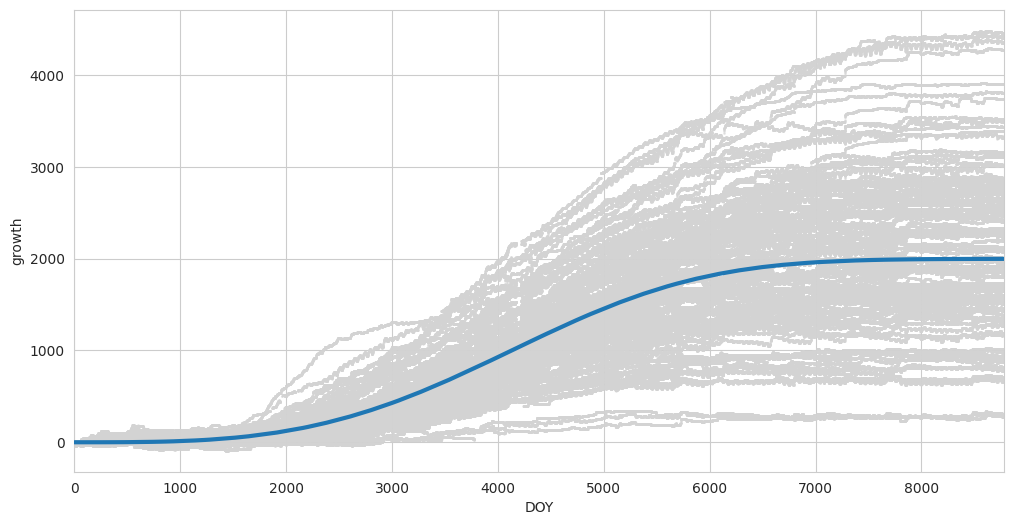

In [109]:
plt.figure(figsize=(12, 6))
X_test = np.linspace(0, dendro_spcs.DOY.max(), 5000).reshape(-1, 1)

#print(gp_model.kernel_)
mean_pred, std_pred = gp_model.predict(X_test, True)
#y_samples = gp_model.sample_y(X_test, 1)

mean_pred += weibull(X_test)
plt.plot(
    X_test, mean_pred, lw=3, zorder=10
)

# sns.lineplot(data=dendro_spcs, x="DOY", y="growth", units="dendroNr", lw=0.8, estimator=None, c="lightgray", alpha=0.3,
#              zorder=-3
#              )
plt.scatter(dendro_spcs.DOY, dendro_spcs.growth,c ="lightgray", alpha=0.5, s = 1)
# plt.fill_between(
#     X_test.ravel(),
#     mean_pred - 1.96 * std_pred,
#     mean_pred + 1.96 * std_pred,
#     color="k", alpha=.1, zorder=0,
# )
# for idx, single_prior in enumerate(y_samples.T):
#     plt.plot(
#         X_test, single_prior + weibull(X_test)
#         , alpha=.4, lw=1, linestyle="dashed"
#     )
#plt.plot(X_train, y_train + weibull(X_train), c = "r")
plt.xlabel("DOY")
plt.ylabel("growth")
plt.xlim(0, dendro_spcs.DOY.max())
plt.show()